# Will This Person Repay Their Bank Loan?
## A Beginner's Guide to Logistic Regression Classification

---

### The Story Behind This Notebook

Imagine you work at a bank. Every day, people walk in and ask to borrow money. Your job is to decide:

> **"Should we give this person a loan — or are they too risky?"**

In the old days, a loan officer would sit down with the applicant, look at their salary, their credit history, and their debts — and then make a gut-feeling decision. Today, banks use **machine learning** to make this decision automatically, faster, and more consistently.

In this notebook, we will build a model that looks at a customer's **annual income** and predicts whether they are likely to **repay the loan (✅)** or **default on it (❌)**.

The technique we use is called **Logistic Regression** — and by the end, you'll understand exactly how it works.

---

### What You Will Learn

| Step | Concept | Plain English Summary |
| :--- | :--- | :--- |
| 0 | Linear Regression Recap | Why the tool we already know **doesn't work** for yes/no decisions |
| 1 | The Sigmoid Function | The clever S-shaped curve that converts any number into a **probability** |
| 2 | Statistical Classification | What it means to sort people into **categories** |
| 3 | Building the Classifier | Actually **training a model** in Python with scikit-learn |
| 4 | Log-Loss | How we measure **how wrong** our model is (so we can make it better) |
| 5 | Talking Points | 3 key ideas to **explain this to others** |

---

## Setup: Importing Our Tools

Before we start, we need to load the Python libraries we'll use throughout this notebook.

Think of these as the **toolbox** we open before starting a project:
- `numpy` → handles numbers and math
- `matplotlib` → draws our charts
- `sklearn` → the machine learning library that does the heavy lifting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score

print("All libraries loaded successfully!")

All libraries loaded successfully!


---

## Section 0: Why Linear Regression Won't Work Here (Recap)

### What is Linear Regression?

You've already seen **Linear Regression** — it's a tool that draws a straight line through data to predict a **continuous number**. For example: *"If a customer earns \$50,000 a year, how much of a loan can they afford?"* — that's a continuous answer (e.g., \$12,500).

### But what if the answer is just YES or NO?

Our loan repayment problem is different. We don't want a number — we want a **decision**:
- **1** = Yes, this person will repay the loan ✅
- **0** = No, this person will default ❌

Let's try to use Linear Regression anyway and see what happens...

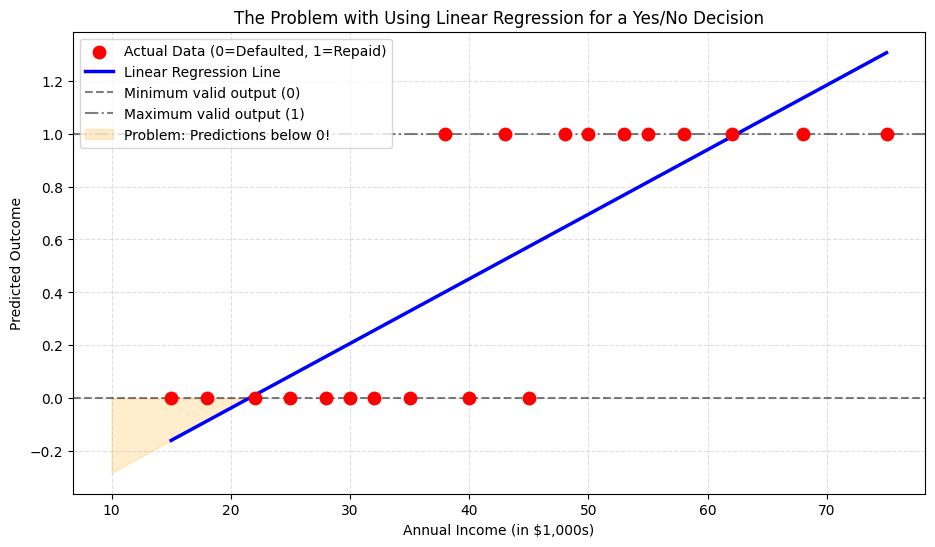

Predictions from Linear Regression for low-income customers:
  Income = $10,000 → Predicted outcome = -0.28  ← This makes no sense!
  Income = $15,000 → Predicted outcome = -0.16  ← This makes no sense!
  Income = $20,000 → Predicted outcome = -0.04  ← This makes no sense!


In [2]:
# Our dataset: Annual income (in $1,000s) vs. whether the person repaid their loan
# Income values range from $15,000 to $75,000
annual_income = np.array([
    15, 18, 22, 25, 28, 30, 32, 35, 38, 40,
    43, 45, 48, 50, 53, 55, 58, 62, 68, 75
]).reshape(-1, 1)

# 0 = Defaulted (did NOT repay), 1 = Repaid successfully
loan_repaid = np.array([
    0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
    1, 0, 1, 1, 1, 1, 1, 1, 1, 1
])

# --- Fit a Linear Regression model ---
linear_model = LinearRegression()
linear_model.fit(annual_income, loan_repaid)
linear_predictions = linear_model.predict(annual_income)

# --- Plot the result ---
plt.figure(figsize=(11, 6))
plt.scatter(annual_income, loan_repaid, color='red', zorder=20, s=80,
            label='Actual Data (0=Defaulted, 1=Repaid)')
plt.plot(annual_income, linear_predictions, color='blue', linewidth=2.5,
         label='Linear Regression Line')

# Draw horizontal lines to mark the only valid outcomes (0 and 1)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Minimum valid output (0)')
plt.axhline(y=1, color='black', linestyle='-.', alpha=0.5, label='Maximum valid output (1)')

# Highlight the "danger zone" where the line goes below 0
x_fill = np.linspace(10, 32, 100)
y_fill = linear_model.predict(x_fill.reshape(-1, 1))
plt.fill_between(x_fill, y_fill, 0, where=(y_fill < 0), alpha=0.2, color='orange',
                 label='Problem: Predictions below 0!')

plt.xlabel('Annual Income (in $1,000s)')
plt.ylabel('Predicted Outcome')
plt.title('The Problem with Using Linear Regression for a Yes/No Decision')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

# Show some problematic predictions
print("Predictions from Linear Regression for low-income customers:")
for income in [10, 15, 20]:
    pred = linear_model.predict([[income]])[0]
    print(f"  Income = ${income},000 → Predicted outcome = {pred:.2f}  ← This makes no sense!")

### What Just Went Wrong? 🤔

Look at the orange shaded area — that's where Linear Regression predicts values **below 0** (like -0.3 or -0.5). But what does a "probability of -0.3" even mean? **Nothing.** Probabilities must always be between 0 and 1.

This is the core problem:

> **Linear Regression was designed for continuous outputs (like price or temperature). It was NOT designed for yes/no classification problems.**

We need a smarter tool — one that is **naturally constrained** to produce values between 0 and 1. That tool is **Logistic Regression**.

---

## Section 1: The Secret Weapon — The Sigmoid (S-Curve) Function

### The Big Idea

Logistic Regression's secret is a clever mathematical function called the **Sigmoid function** (also called the **logistic function**). It takes ANY number you throw at it — positive, negative, huge, tiny — and squishes it into a value between **0 and 1**.

This makes it perfect for representing **probability**.

### The Formula

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

Where:
- $z$ is just a regular number (could be anything: -100, 0, 5, 1000...)
- $e$ is Euler's number (~2.718), the base of the natural logarithm
- $\sigma(z)$ is the output — always a value between 0 and 1

In our bank loan case:
- $z$ is calculated from the customer's income (using a formula the model learns)
- $\sigma(z)$ = **"the probability this customer will repay the loan"**

### Why is it Called a "Sigmoid"?

Because it looks like the letter **S**! As you'll see in the chart below:
- Very low incomes → probability close to **0** (almost certainly will default)
- Very high incomes → probability close to **1** (almost certainly will repay)
- Medium incomes → probability near **0.5** (it's a coin flip)

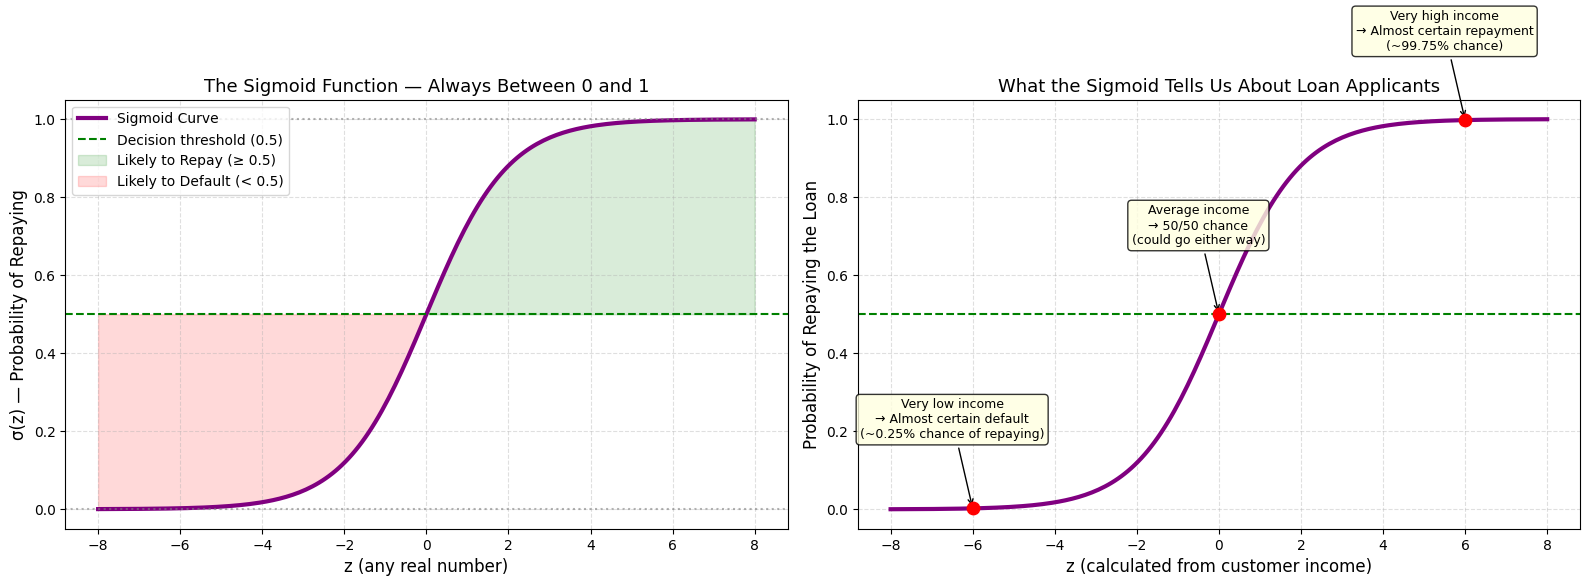

Sigmoid function output for different z values:
  σ( -10) = 0.000045  → Always between 0 and 1 ✓
  σ(  -5) = 0.006693  → Always between 0 and 1 ✓
  σ(  -2) = 0.119203  → Always between 0 and 1 ✓
  σ(   0) = 0.500000  → Always between 0 and 1 ✓
  σ(   2) = 0.880797  → Always between 0 and 1 ✓
  σ(   5) = 0.993307  → Always between 0 and 1 ✓
  σ(  10) = 0.999955  → Always between 0 and 1 ✓


In [3]:
def sigmoid(z):
    """The sigmoid function: squishes any number into the range (0, 1)"""
    return 1 / (1 + np.exp(-z))

# Generate a range of z values to plot the S-curve
z_values = np.linspace(-8, 8, 200)
sigmoid_values = sigmoid(z_values)

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LEFT PLOT: Pure sigmoid curve
ax1 = axes[0]
ax1.plot(z_values, sigmoid_values, color='purple', linewidth=3, label='Sigmoid Curve')
ax1.axhline(y=0.5, color='green', linestyle='--', linewidth=1.5, label='Decision threshold (0.5)')
ax1.axhline(y=0, color='grey', linestyle=':', alpha=0.6)
ax1.axhline(y=1, color='grey', linestyle=':', alpha=0.6)
ax1.fill_between(z_values, sigmoid_values, 0.5, where=(sigmoid_values >= 0.5),
                 alpha=0.15, color='green', label='Likely to Repay (≥ 0.5)')
ax1.fill_between(z_values, sigmoid_values, 0.5, where=(sigmoid_values < 0.5),
                 alpha=0.15, color='red', label='Likely to Default (< 0.5)')
ax1.set_xlabel('z (any real number)', fontsize=12)
ax1.set_ylabel('σ(z) — Probability of Repaying', fontsize=12)
ax1.set_title('The Sigmoid Function — Always Between 0 and 1', fontsize=13)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.4)

# RIGHT PLOT: Annotated with intuitive examples
ax2 = axes[1]
ax2.plot(z_values, sigmoid_values, color='purple', linewidth=3)
ax2.axhline(y=0.5, color='green', linestyle='--', linewidth=1.5)

# Annotate interesting points on the curve
annotations = [
    (-6, sigmoid(-6), 'Very low income\n→ Almost certain default\n(~0.25% chance of repaying)'),
    (0,  sigmoid(0),  'Average income\n→ 50/50 chance\n(could go either way)'),
    (6,  sigmoid(6),  'Very high income\n→ Almost certain repayment\n(~99.75% chance)'),
]

for x, y, label in annotations:
    ax2.annotate(label, xy=(x, y), xytext=(x - 0.5, y + 0.18),
                 fontsize=9, ha='center',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.8),
                 arrowprops=dict(arrowstyle='->', color='black'))
    ax2.scatter([x], [y], color='red', zorder=5, s=80)

ax2.set_xlabel('z (calculated from customer income)', fontsize=12)
ax2.set_ylabel('Probability of Repaying the Loan', fontsize=12)
ax2.set_title('What the Sigmoid Tells Us About Loan Applicants', fontsize=13)
ax2.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

# Show how the sigmoid behaves at specific values
print("Sigmoid function output for different z values:")
for z in [-10, -5, -2, 0, 2, 5, 10]:
    print(f"  σ({z:4d}) = {sigmoid(z):.6f}  → Always between 0 and 1 ✓")

### Key Takeaway 💡

No matter what number you put into the sigmoid function, the output is **always between 0 and 1**. This is exactly what we need to represent a probability.

The sigmoid is like a **translator**: it takes a raw score (which could be any number) and converts it into a clean probability that everyone can understand:

| Sigmoid Output | What It Means for Our Bank |
| :--- | :--- |
| 0.95 | "95% confident this person will repay — APPROVE the loan" |
| 0.50 | "It's a coin flip — we might want more information" |
| 0.08 | "Only 8% chance of repayment — REJECT the loan" |

---

## Section 2: Understanding Statistical Classification

### What Does "Classification" Mean?

**Classification** is the process of looking at some information about something and assigning it to a **category** (also called a *class*).

You do this every day without thinking:
- You look at the sky → "cloudy" or "sunny" ☁️☀️
- You get an email → "spam" or "not spam" 📧
- A doctor reads an X-ray → "cancerous" or "benign" 🏥
- The bank reviews an application → **"will repay" or "will default"** 🏦

### Key Vocabulary (in Plain English)

| Term | Plain English | Our Loan Example |
| :--- | :--- | :--- |
| **Classifier** | The algorithm that makes the sorting decision | Logistic Regression |
| **Features** | The pieces of information we use to decide | Annual income, credit score |
| **Classes / Labels** | The possible categories we sort into | `0 = Default`, `1 = Repaid` |
| **Decision Boundary** | The invisible line that separates the two classes | Income level where 50% chance flips |
| **Training Data** | Historical examples the model learns from | Past customers and their repayment history |

### Visualizing a Decision Boundary

The chart below shows how the model learns to draw an invisible line between "safe" and "risky" loan applicants. Any new customer that falls on one side of the line is approved; on the other side, rejected.

c:\Projects\LogisticRegressionClassifier_Workshop\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Projects\LogisticRegressionClassifier_Workshop\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


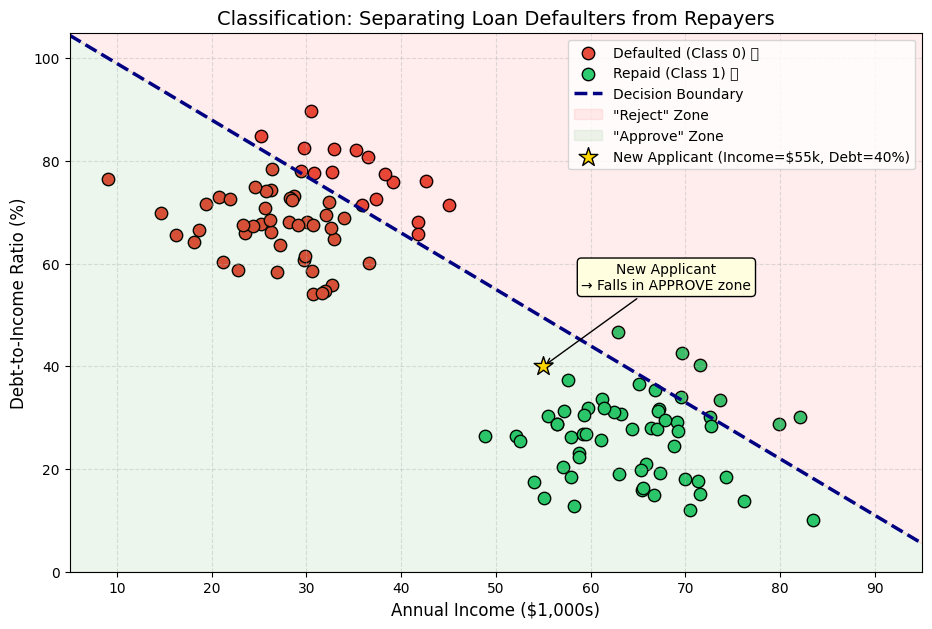

The model's job: find the best possible decision boundary line
that correctly separates the two classes in our training data.


In [4]:
from sklearn.datasets import make_blobs

# Simulate two groups of bank customers:
#   Group 0 (defaulted): lower income, higher debt
#   Group 1 (repaid):    higher income, lower debt
# We use 2 features so we can visualize them on a 2D chart.
np.random.seed(42)
X_customers, y_customers = make_blobs(
    n_samples=120,
    centers=[(30, 70), (65, 25)],   # (income, debt-to-income ratio)
    n_features=2,
    cluster_std=8,
    random_state=42
)

# Draw the decision boundary manually (a straight line)
x_boundary = np.linspace(5, 95, 100)
y_boundary = -1.1 * x_boundary + 110  # This is approximately where the boundary falls

# --- Plot ---
plt.figure(figsize=(11, 7))

# Plot the two groups of customers
defaulted = y_customers == 0
repaid    = y_customers == 1
plt.scatter(X_customers[defaulted, 0], X_customers[defaulted, 1],
            color='#e74c3c', edgecolor='black', s=80, label='Defaulted (Class 0) ❌')
plt.scatter(X_customers[repaid, 0], X_customers[repaid, 1],
            color='#2ecc71', edgecolor='black', s=80, label='Repaid (Class 1) ✅')

# Plot the decision boundary
plt.plot(x_boundary, y_boundary, color='navy', linestyle='--', linewidth=2.5,
         label='Decision Boundary')

# Shade the two regions
plt.fill_between(x_boundary, y_boundary, 110,
                 alpha=0.07, color='red', label='"Reject" Zone')
plt.fill_between(x_boundary, 0, y_boundary,
                 alpha=0.07, color='green', label='"Approve" Zone')

# Add labels for a new applicant
plt.scatter([55], [40], color='gold', edgecolor='black', s=200, zorder=10,
            marker='*', label='New Applicant (Income=$55k, Debt=40%)')
plt.annotate('New Applicant\n→ Falls in APPROVE zone',
             xy=(55, 40), xytext=(68, 55),
             fontsize=10, ha='center',
             bbox=dict(boxstyle='round', facecolor='lightyellow'),
             arrowprops=dict(arrowstyle='->', color='black'))

plt.xlabel('Annual Income ($1,000s)', fontsize=12)
plt.ylabel('Debt-to-Income Ratio (%)', fontsize=12)
plt.title('Classification: Separating Loan Defaulters from Repayers', fontsize=14)
plt.legend(loc='upper right')
plt.xlim(5, 95)
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

print("The model's job: find the best possible decision boundary line")
print("that correctly separates the two classes in our training data.")

### What the Chart Tells Us

The dashed blue line is the **decision boundary** — the bank's automatic dividing line between "approve" and "reject".

- **Red dots** = past customers who defaulted (the bank lost money on them)
- **Green dots** = past customers who repaid successfully
- **Gold star** = a new applicant the bank needs to evaluate today

The model learned this boundary by studying thousands of past customers. Now, when a new applicant comes in, the bank just checks which side of the line they fall on — and makes an instant decision.

> **Real-world note:** Banks actually use dozens (or even hundreds) of features — not just 2. The decision boundary becomes a multi-dimensional surface, but the idea is exactly the same.

---

## Section 3: Building Our Loan Repayment Classifier

### From Theory to Code

Now let's build the actual classifier! We'll use our original dataset (annual income vs. loan outcome) and train a Logistic Regression model using `scikit-learn`.

### The Decision Rule (Threshold)

Once the sigmoid gives us a probability, we apply a simple decision rule:

| Probability of Repayment | Bank's Decision |
| :--- | :--- |
| ≥ 0.5 (50%) | **Approve** the loan (classify as `1 = Repaid`) |
| < 0.5 (50%) | **Reject** the loan (classify as `0 = Default`) |

The 0.5 threshold is the default, but in real life banks might raise it to 0.7 to be more conservative (reject more people) or lower it to reduce false rejections. This is a **business decision**, not just a mathematical one.

### Let's Build It Step by Step

In [5]:
# ============================================================
# STEP 1: Our Dataset
# ============================================================
# Annual income in $1,000s. E.g., 15 means $15,000/year
annual_income = np.array([
    15, 18, 22, 25, 28, 30, 32, 35, 38, 40,
    43, 45, 48, 50, 53, 55, 58, 62, 68, 75
]).reshape(-1, 1)

# 0 = Defaulted, 1 = Repaid
loan_repaid = np.array([
    0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
    1, 0, 1, 1, 1, 1, 1, 1, 1, 1
])

# ============================================================
# STEP 2: Create and Train the Logistic Regression Model
# ============================================================
# Think of .fit() as "learning from historical data"
log_reg = LogisticRegression()
log_reg.fit(annual_income, loan_repaid)
print("✅ Model trained successfully!")

# ============================================================
# STEP 3: Make Predictions
# ============================================================
# Get probabilities for all training customers
# predict_proba returns [[prob_class_0, prob_class_1], ...]
probabilities = log_reg.predict_proba(annual_income)

# Get the final classification (0 or 1) for each customer
predictions = log_reg.predict(annual_income)

print("\n📊 First 5 customers' predictions:")
print(f"{'Income':>10} {'Actual':>10} {'P(Default)':>12} {'P(Repay)':>12} {'Decision':>12}")
print("-" * 60)
for i in range(5):
    inc    = annual_income[i][0]
    actual = loan_repaid[i]
    p0     = probabilities[i][0]
    p1     = probabilities[i][1]
    dec    = predictions[i]
    flag   = '✅' if dec == actual else '❌'
    print(f"  ${inc:>5}k     {actual:>7}   {p0:>10.1%}   {p1:>10.1%}   {dec:>5} {flag}")

print("\n... (truncated for brevity)")

# ============================================================
# STEP 4: Evaluate the Model
# ============================================================
accuracy = accuracy_score(loan_repaid, predictions)
print(f"\n🎯 Model Accuracy: {accuracy * 100:.1f}%")
print(f"   → The model correctly classified {int(accuracy * len(loan_repaid))} out of {len(loan_repaid)} customers.")

# ============================================================
# STEP 5: Predict for a Brand-New Applicant
# ============================================================
print("\n" + "=" * 60)
print("NEW LOAN APPLICATION")
print("=" * 60)

new_applicant_income = 42  # $42,000 per year
new_applicant = np.array([[new_applicant_income]])

prob_default = log_reg.predict_proba(new_applicant)[0][0]
prob_repay   = log_reg.predict_proba(new_applicant)[0][1]
decision     = log_reg.predict(new_applicant)[0]

print(f"  Applicant's Annual Income: ${new_applicant_income},000")
print(f"  Probability of Default:    {prob_default:.1%}")
print(f"  Probability of Repayment:  {prob_repay:.1%}")
print(f"  Model's Decision:          {'APPROVE ✅' if decision == 1 else 'REJECT ❌'}")

✅ Model trained successfully!

📊 First 5 customers' predictions:
    Income     Actual   P(Default)     P(Repay)     Decision
------------------------------------------------------------
  $   15k           0       100.0%         0.0%       0 ✅
  $   18k           0        99.9%         0.1%       0 ✅
  $   22k           0        99.7%         0.3%       0 ✅
  $   25k           0        99.3%         0.7%       0 ✅
  $   28k           0        98.3%         1.7%       0 ✅

... (truncated for brevity)

🎯 Model Accuracy: 90.0%
   → The model correctly classified 18 out of 20 customers.

NEW LOAN APPLICATION
  Applicant's Annual Income: $42,000
  Probability of Default:    46.0%
  Probability of Repayment:  54.0%
  Model's Decision:          APPROVE ✅


c:\Projects\LogisticRegressionClassifier_Workshop\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Projects\LogisticRegressionClassifier_Workshop\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


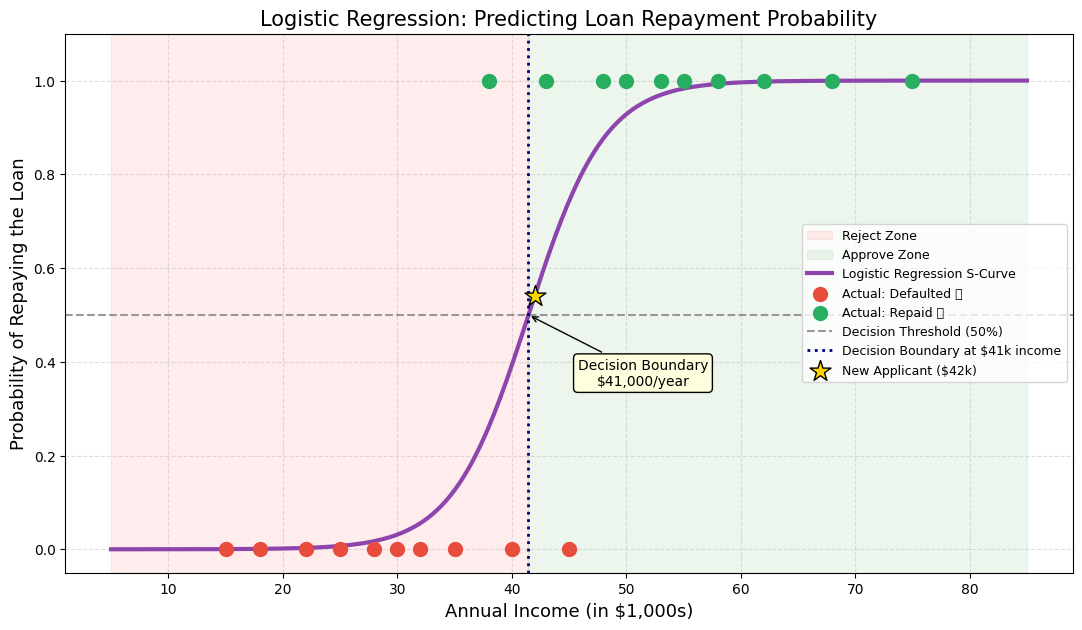

The model's decision boundary: customers earning more than ~$41,000/year
are classified as 'likely to repay' (probability ≥ 50%).


In [6]:
# ============================================================
# STEP 6: Visualize the Trained Model
# ============================================================

# Generate a smooth range of income values for the S-curve
x_smooth = np.linspace(5, 85, 300).reshape(-1, 1)
y_prob_smooth = log_reg.predict_proba(x_smooth)[:, 1]  # probability of repayment

# Find the decision boundary (where probability = 50%)
# Solved from: 0 = intercept + coef * x  →  x = -intercept / coef
decision_boundary = -log_reg.intercept_[0] / log_reg.coef_[0][0]

# --- Plot ---
plt.figure(figsize=(13, 7))

# Shade the approve/reject zones
plt.axvspan(5, decision_boundary, alpha=0.07, color='red', label='Reject Zone')
plt.axvspan(decision_boundary, 85, alpha=0.07, color='green', label='Approve Zone')

# Plot the S-curve
plt.plot(x_smooth, y_prob_smooth, color='#8e44ad', linewidth=3,
         label='Logistic Regression S-Curve')

# Plot the actual training data
plt.scatter(annual_income[loan_repaid == 0], loan_repaid[loan_repaid == 0],
            color='#e74c3c', s=100, zorder=10, label='Actual: Defaulted ❌')
plt.scatter(annual_income[loan_repaid == 1], loan_repaid[loan_repaid == 1],
            color='#27ae60', s=100, zorder=10, label='Actual: Repaid ✅')

# Mark the decision threshold line (p=0.5)
plt.axhline(y=0.5, color='grey', linestyle='--', alpha=0.8, label='Decision Threshold (50%)')

# Mark the decision boundary (income value where probability = 0.5)
plt.axvline(x=decision_boundary, color='navy', linestyle=':', linewidth=2,
            label=f'Decision Boundary at ${decision_boundary:.0f}k income')
plt.annotate(f'Decision Boundary\n${decision_boundary:.0f},000/year',
             xy=(decision_boundary, 0.5), xytext=(decision_boundary + 10, 0.35),
             fontsize=10, ha='center',
             bbox=dict(boxstyle='round', facecolor='lightyellow'),
             arrowprops=dict(arrowstyle='->', color='black'))

# Mark the new applicant
plt.scatter([new_applicant_income], [prob_repay], color='gold', edgecolor='black',
            s=250, zorder=15, marker='*', label=f'New Applicant (${new_applicant_income}k)')

plt.xlabel('Annual Income (in $1,000s)', fontsize=13)
plt.ylabel('Probability of Repaying the Loan', fontsize=13)
plt.title('Logistic Regression: Predicting Loan Repayment Probability', fontsize=15)
plt.legend(loc='center right', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.4)
plt.ylim(-0.05, 1.1)
plt.show()

print(f"The model's decision boundary: customers earning more than ~${decision_boundary:.0f},000/year")
print(f"are classified as 'likely to repay' (probability ≥ 50%).")

### Reading the Chart

- The **purple S-curve** is what our model learned from the historical data. It represents the probability of repayment at each income level.
- The **red zone** on the left = income too low → model says "REJECT"
- The **green zone** on the right = income high enough → model says "APPROVE"
- The **navy dotted line** is the exact income level where the model switches from reject to approve
- The **gold star** is our new applicant — notice where it falls on the curve!

> **In real banking systems:** The model would use many more features (credit score, existing debts, employment length, etc.). But the core logic is identical — the sigmoid converts everything into a probability, and the threshold makes the final call.

---

## Section 4: Log-Loss — How Do We Know if Our Model is Good?

### The Problem with Just Counting Correct Answers

Imagine two bank employees evaluating the same loan application:
- **Employee A** says: *"I'm 99% sure this person will default"* → then they do default ✅
- **Employee B** says: *"I'm 51% sure this person will default"* → then they do default ✅

Both got it right, but **Employee A was much more confident and accurate**. Simple accuracy ("how many did you get right?") treats them the same. That's not fair.

This is where **Log-Loss** comes in. It rewards confident correct predictions and severely punishes confident wrong predictions.

### The Formula

For a single prediction:

$$\text{Loss} = -\left[ y \cdot \log(p) + (1 - y) \cdot \log(1 - p) \right]$$

Breaking this down:
- $y$ = the **true outcome** (1 if repaid, 0 if defaulted)
- $p$ = the **model's predicted probability** that the person will repay
- When $y=1$: loss = $-\log(p)$ → low loss if $p$ is high (model was confidently right)
- When $y=0$: loss = $-\log(1-p)$ → low loss if $p$ is low (model correctly said "unlikely to repay")

For the whole dataset of $N$ customers:

$$\text{Total Log-Loss} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(p_i) + (1 - y_i) \cdot \log(1 - p_i) \right]$$

### Plain English Summary

| Scenario | Loss |
| :--- | :--- |
| Model says 95% chance of repayment → Customer **REPAYS** | Very low (model was right and confident) |
| Model says 50% chance of repayment → Customer **REPAYS** | Medium (model was right but unsure) |
| Model says 95% chance of repayment → Customer **DEFAULTS** | Very high (model was catastrophically wrong) |

> **Lower log-loss = better model.** The goal of training is to minimize this number.

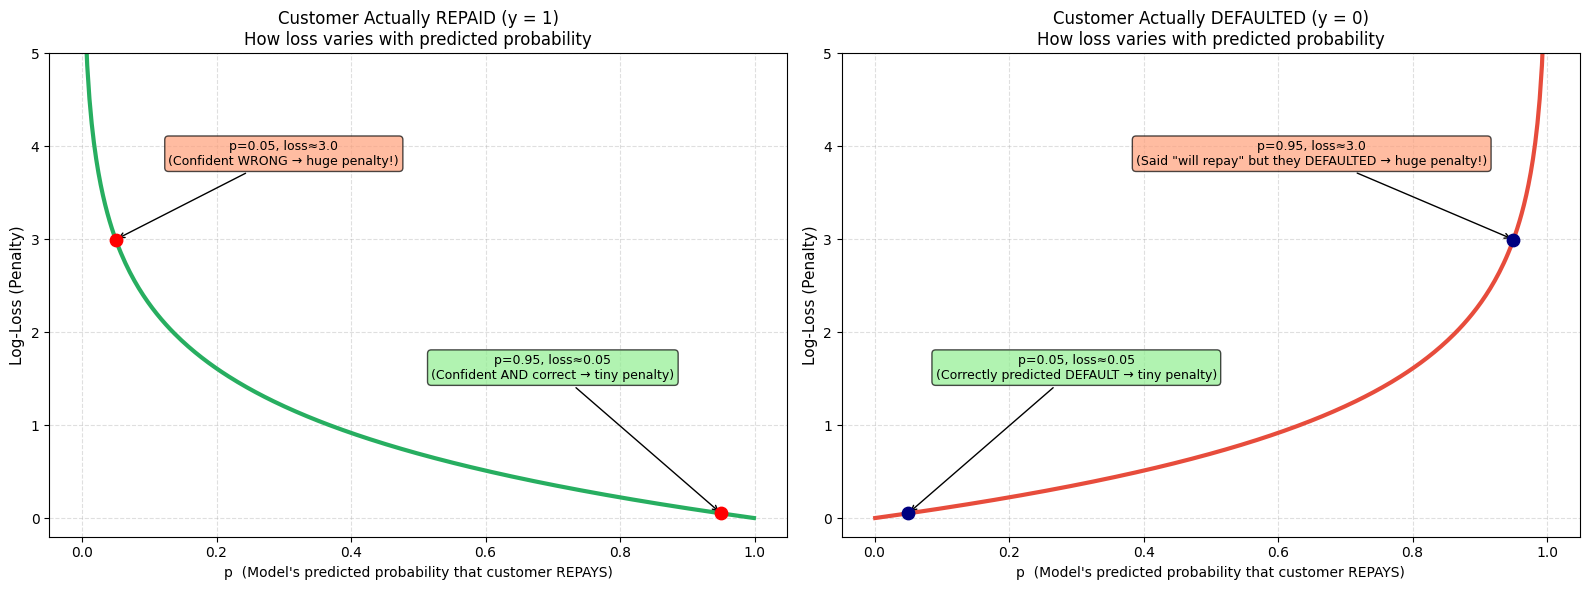

In [7]:
# ============================================================
# Intuition: How Log-Loss Penalizes Confident Wrong Predictions
# ============================================================

# Case 1: True label y=1 (customer REPAID)
# Case 2: True label y=0 (customer DEFAULTED)

p_range = np.linspace(0.001, 0.999, 300)  # All possible predicted probabilities
loss_y1 = -np.log(p_range)          # Loss when true label is 1
loss_y0 = -np.log(1 - p_range)      # Loss when true label is 0

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---- LEFT: When Customer Actually REPAID (y=1) ----
ax1 = axes[0]
ax1.plot(p_range, loss_y1, color='#27ae60', linewidth=3)
ax1.set_title('Customer Actually REPAID (y = 1)\nHow loss varies with predicted probability', fontsize=12)
ax1.set_xlabel('p  (Model\'s predicted probability that customer REPAYS)', fontsize=10)
ax1.set_ylabel('Log-Loss (Penalty)', fontsize=11)

# Annotate key points
ax1.annotate('p=0.95, loss≈0.05\n(Confident AND correct → tiny penalty)',
             xy=(0.95, -np.log(0.95)), xytext=(0.7, 1.5),
             fontsize=9, ha='center',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
             arrowprops=dict(arrowstyle='->', color='black'))
ax1.annotate('p=0.05, loss≈3.0\n(Confident WRONG → huge penalty!)',
             xy=(0.05, -np.log(0.05)), xytext=(0.3, 3.8),
             fontsize=9, ha='center',
             bbox=dict(boxstyle='round', facecolor='lightsalmon', alpha=0.7),
             arrowprops=dict(arrowstyle='->', color='black'))
ax1.scatter([0.95, 0.05], [-np.log(0.95), -np.log(0.05)],
            color='red', zorder=5, s=80)
ax1.set_ylim(-0.2, 5)
ax1.grid(True, linestyle='--', alpha=0.4)

# ---- RIGHT: When Customer Actually DEFAULTED (y=0) ----
ax2 = axes[1]
ax2.plot(p_range, loss_y0, color='#e74c3c', linewidth=3)
ax2.set_title('Customer Actually DEFAULTED (y = 0)\nHow loss varies with predicted probability', fontsize=12)
ax2.set_xlabel('p  (Model\'s predicted probability that customer REPAYS)', fontsize=10)
ax2.set_ylabel('Log-Loss (Penalty)', fontsize=11)

ax2.annotate('p=0.05, loss≈0.05\n(Correctly predicted DEFAULT → tiny penalty)',
             xy=(0.05, -np.log(1-0.05)), xytext=(0.3, 1.5),
             fontsize=9, ha='center',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
             arrowprops=dict(arrowstyle='->', color='black'))
ax2.annotate('p=0.95, loss≈3.0\n(Said "will repay" but they DEFAULTED → huge penalty!)',
             xy=(0.95, -np.log(1-0.95)), xytext=(0.65, 3.8),
             fontsize=9, ha='center',
             bbox=dict(boxstyle='round', facecolor='lightsalmon', alpha=0.7),
             arrowprops=dict(arrowstyle='->', color='black'))
ax2.scatter([0.05, 0.95], [-np.log(1-0.05), -np.log(1-0.95)],
            color='navy', zorder=5, s=80)
ax2.set_ylim(-0.2, 5)
ax2.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [8]:
# ============================================================
# Calculate Log-Loss for Our Bank Loan Model
# ============================================================

def calculate_log_loss(y_true, y_prob):
    """
    Compute the average log-loss (cross-entropy loss) for a set of predictions.
    
    Parameters:
        y_true  : array of actual outcomes (0 or 1)
        y_prob  : array of predicted probabilities for class 1 (repayment)
    
    Returns:
        float: The average log-loss across all samples
    """
    eps = 1e-15  # Tiny buffer to prevent log(0) errors
    y_prob = np.clip(y_prob, eps, 1 - eps)
    individual_losses = -(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))
    return individual_losses, np.mean(individual_losses)


# Get probabilities of repayment from our trained model
p_repay = probabilities[:, 1]

# Calculate losses
individual_losses, total_log_loss = calculate_log_loss(loan_repaid, p_repay)

# --- Display a customer-by-customer breakdown ---
print("Customer-by-Customer Log-Loss Breakdown:")
print(f"{'Customer':>10} {'Income':>8} {'Actual':>8} {'P(Repay)':>10} {'Loss':>10} {'Note'}")
print("-" * 70)

for i in range(len(loan_repaid)):
    inc    = annual_income[i][0]
    actual = loan_repaid[i]
    prob   = p_repay[i]
    loss   = individual_losses[i]
    # Flag: was this a bad prediction? (high loss = bad)
    note = "⚠️  High penalty!" if loss > 1.0 else "✅ Good prediction"
    print(f"  #{i+1:>4}     ${inc:>4}k   {actual:>6}   {prob:>9.1%}   {loss:>9.4f}   {note}")

print("-" * 70)
print(f"\n📊 Total Log-Loss (averaged over all customers): {total_log_loss:.4f}")
print("\nInterpretation:")
print(f"  A log-loss of {total_log_loss:.4f} means our model's probability estimates")
print(f"  are well-calibrated — it's confident when it should be, and uncertain")
print(f"  when the data is ambiguous.")
print(f"\n  Perfect model → Log-Loss = 0")
print(f"  Random guessing → Log-Loss ≈ 0.693")
print(f"  Our model → Log-Loss = {total_log_loss:.4f}  (lower than random = better than guessing!) ✅")

Customer-by-Customer Log-Loss Breakdown:
  Customer   Income   Actual   P(Repay)       Loss Note
----------------------------------------------------------------------
  #   1     $  15k        0        0.0%      0.0004   ✅ Good prediction
  #   2     $  18k        0        0.1%      0.0009   ✅ Good prediction
  #   3     $  22k        0        0.3%      0.0029   ✅ Good prediction
  #   4     $  25k        0        0.7%      0.0072   ✅ Good prediction
  #   5     $  28k        0        1.7%      0.0176   ✅ Good prediction
  #   6     $  30k        0        3.1%      0.0318   ✅ Good prediction
  #   7     $  32k        0        5.6%      0.0572   ✅ Good prediction
  #   8     $  35k        0       12.6%      0.1349   ✅ Good prediction
  #   9     $  38k        1       26.2%      1.3398   ⚠️  High penalty!
  #  10     $  40k        0       39.2%      0.4983   ✅ Good prediction
  #  11     $  43k        1       61.3%      0.4887   ✅ Good prediction
  #  12     $  45k        0       74.3% 

### How Training Actually Works (The Big Picture)

When we call `log_reg.fit(...)`, here's what happens under the hood:

1. The model starts with **random guesses** for its internal parameters (weights)
2. It makes predictions and **calculates the log-loss** — how wrong it is
3. It **adjusts the parameters** slightly to reduce the log-loss
4. Steps 2–3 repeat **hundreds of times** until the loss stops decreasing

This process is called **Gradient Descent** — like rolling a ball downhill to find the lowest point (minimum loss).

```
Start → High Loss
        ↓  (adjust parameters)
        ↓  (adjust parameters)
        ↓  (adjust parameters)
End   → Low Loss = Well-trained model!
```

Every classification model — from simple logistic regression to complex neural networks — uses some version of this same process.

---

## Section 5: The Full Picture — Everything We Covered

Let's connect all the pieces together with one final visualization.

C:\Users\muthu\AppData\Local\Temp\ipykernel_22988\3539327662.py:63: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\muthu\AppData\Local\Temp\ipykernel_22988\3539327662.py:63: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Projects\LogisticRegressionClassifier_Workshop\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Projects\LogisticRegressionClassifier_Workshop\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


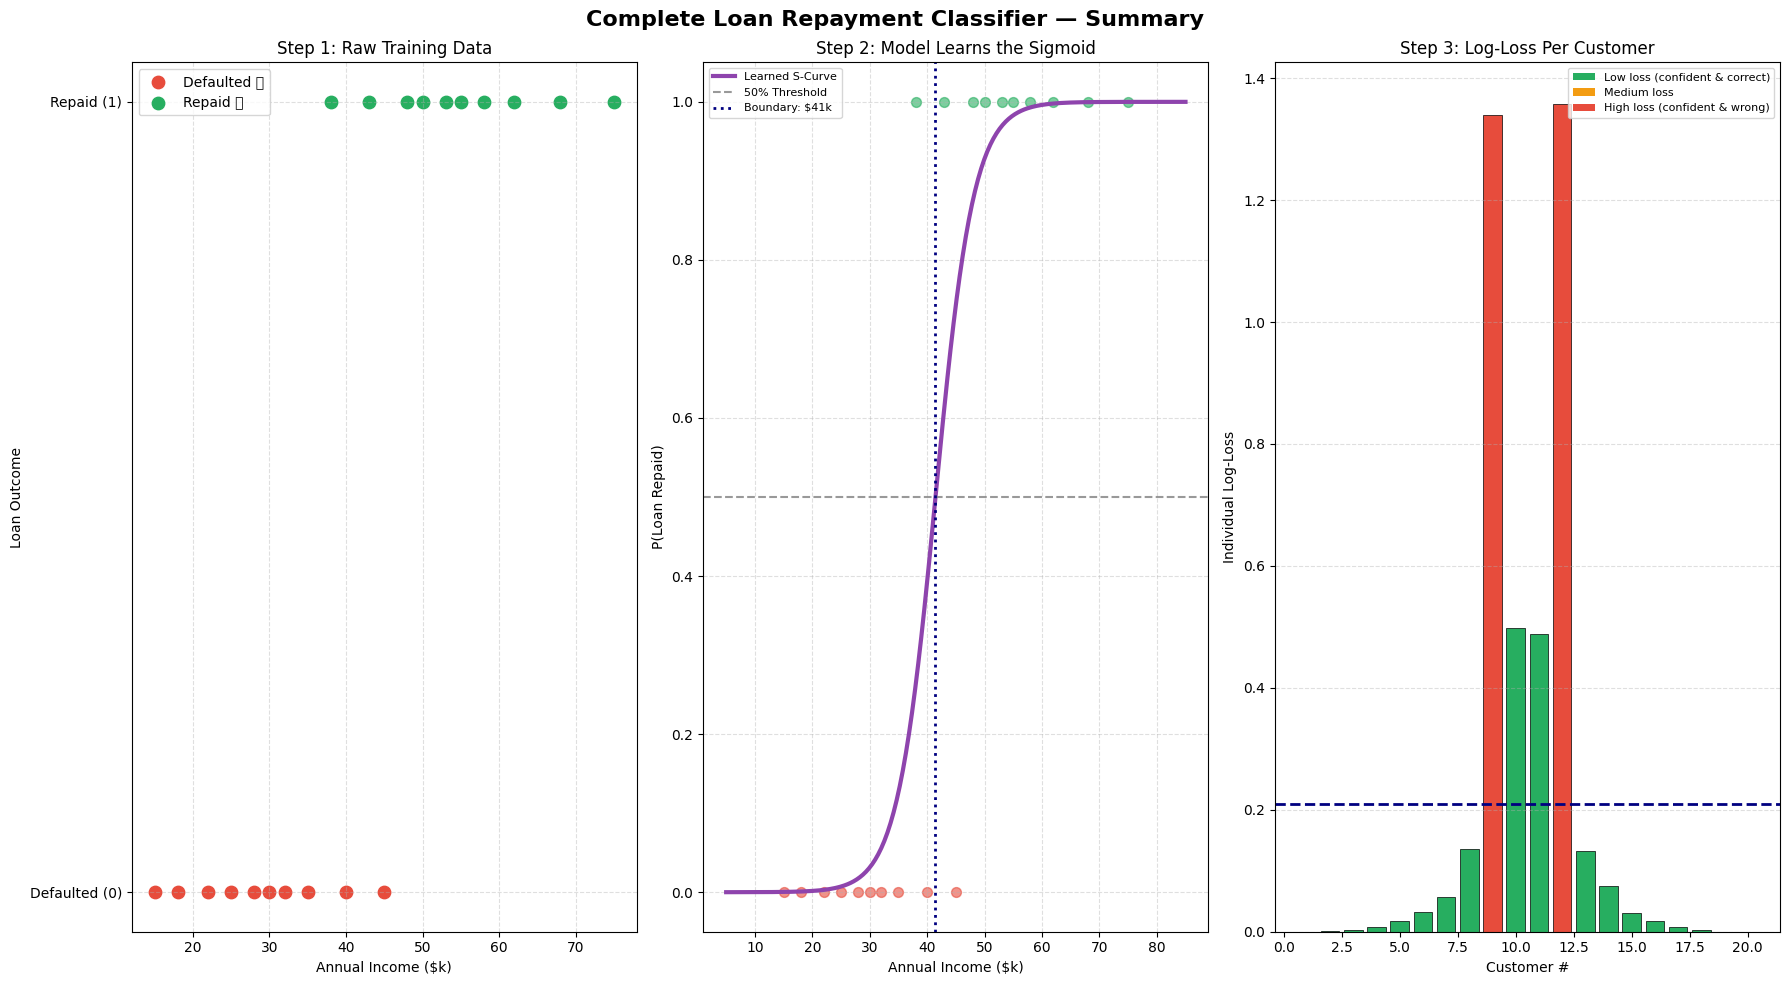

Summary:
  Customers in dataset  : 20
  Model accuracy        : 90.0%
  Average log-loss      : 0.2101
  Decision boundary     : ~$41,000/year income


In [9]:
# ============================================================
# Final Summary: The Complete Logistic Regression Pipeline
# ============================================================

fig = plt.figure(figsize=(18, 10))
fig.suptitle('Complete Loan Repayment Classifier — Summary', fontsize=16, fontweight='bold')

# ---- Plot 1: Raw Data ----
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(annual_income[loan_repaid == 0], loan_repaid[loan_repaid == 0],
            color='#e74c3c', s=80, label='Defaulted ❌')
ax1.scatter(annual_income[loan_repaid == 1], loan_repaid[loan_repaid == 1],
            color='#27ae60', s=80, label='Repaid ✅')
ax1.set_title('Step 1: Raw Training Data', fontsize=12)
ax1.set_xlabel('Annual Income ($k)')
ax1.set_ylabel('Loan Outcome')
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['Defaulted (0)', 'Repaid (1)'])
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.4)

# ---- Plot 2: The Sigmoid Fit ----
ax2 = fig.add_subplot(1, 3, 2)
x_smooth = np.linspace(5, 85, 300).reshape(-1, 1)
y_prob_smooth = log_reg.predict_proba(x_smooth)[:, 1]
ax2.plot(x_smooth, y_prob_smooth, color='#8e44ad', linewidth=3, label='Learned S-Curve')
ax2.axhline(y=0.5, color='grey', linestyle='--', alpha=0.8, label='50% Threshold')
ax2.axvline(x=decision_boundary, color='navy', linestyle=':', linewidth=2,
            label=f'Boundary: ${decision_boundary:.0f}k')
ax2.scatter(annual_income[loan_repaid == 0], loan_repaid[loan_repaid == 0],
            color='#e74c3c', s=50, alpha=0.6)
ax2.scatter(annual_income[loan_repaid == 1], loan_repaid[loan_repaid == 1],
            color='#27ae60', s=50, alpha=0.6)
ax2.set_title('Step 2: Model Learns the Sigmoid', fontsize=12)
ax2.set_xlabel('Annual Income ($k)')
ax2.set_ylabel('P(Loan Repaid)')
ax2.legend(fontsize=8)
ax2.grid(True, linestyle='--', alpha=0.4)

# ---- Plot 3: Loss for Each Customer ----
ax3 = fig.add_subplot(1, 3, 3)
colors = ['#27ae60' if l < 0.5 else ('#f39c12' if l < 1.0 else '#e74c3c')
          for l in individual_losses]
bars = ax3.bar(range(1, len(individual_losses) + 1), individual_losses,
               color=colors, edgecolor='black', linewidth=0.5)
ax3.axhline(y=total_log_loss, color='navy', linestyle='--', linewidth=2,
            label=f'Avg Log-Loss = {total_log_loss:.3f}')
ax3.set_title('Step 3: Log-Loss Per Customer', fontsize=12)
ax3.set_xlabel('Customer #')
ax3.set_ylabel('Individual Log-Loss')
ax3.legend()
ax3.grid(True, linestyle='--', alpha=0.4, axis='y')

# Add a color legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#27ae60', label='Low loss (confident & correct)'),
    Patch(facecolor='#f39c12', label='Medium loss'),
    Patch(facecolor='#e74c3c', label='High loss (confident & wrong)'),
]
ax3.legend(handles=legend_elements, fontsize=8, loc='upper right')

plt.tight_layout()
plt.show()

print("Summary:")
print(f"  Customers in dataset  : {len(loan_repaid)}")
print(f"  Model accuracy        : {accuracy_score(loan_repaid, log_reg.predict(annual_income)) * 100:.1f}%")
print(f"  Average log-loss      : {total_log_loss:.4f}")
print(f"  Decision boundary     : ~${decision_boundary:.0f},000/year income")

---

## What We Built — End-to-End Recap

Congratulations! You just built a complete machine learning classifier. Here's what happened, step by step:

| Step | What We Did | Why It Matters |
| :--- | :--- | :--- |
| **Data** | Collected historical loan outcomes | The model can only learn from examples |
| **Linear Regression Failure** | Showed it gives nonsensical outputs for yes/no problems | Sets up WHY we need something better |
| **Sigmoid Function** | Introduced the S-curve that converts any number to a probability (0–1) | This is what makes Logistic Regression work |
| **Classification** | Defined what it means to assign inputs to categories | The fundamental concept behind the whole field |
| **Training** | Let `scikit-learn` fit the model to our data | The model learned the best sigmoid for our data |
| **Threshold** | Applied the 50% cutoff to turn probability → decision | The bridge from "how likely" to "yes or no" |
| **Log-Loss** | Measured how wrong the model's probabilities are | The feedback signal the model uses to improve |

---

## 3 Talking Points for Class Presentation

Here are three key ideas you can use to explain this topic to other students — each explained in a way that makes it click:

---

### 🎯 Talking Point 1: "Why Logistic, Not Linear?"

> *"Linear regression draws a straight line to predict a number — like predicting tomorrow's temperature. But when the answer is yes or no, a straight line breaks down. It can predict probabilities above 100% or below 0%, which is mathematically impossible. Logistic regression fixes this by using a sigmoid function — an S-shaped curve that always stays between 0 and 1, giving us valid probabilities no matter what inputs we feed it. This is the difference between asking 'how much?' (linear) and asking 'which one?' (logistic)."*

**Anchor example:** *"Imagine asking a straight line: 'What's the probability this unemployed person with $5k in savings will repay a $50k loan?' The line might say -0.4. Logistic regression would say 3% — a much more meaningful answer."*

---

### 🎯 Talking Point 2: "The Decision Boundary is the Model's Opinion"

> *"When a logistic regression model is trained, it learns a decision boundary — an invisible line in your data that separates 'yes' from 'no'. In our loan example, that boundary is an income level: anyone earning above $X gets approved, below gets rejected. The model's entire job during training is to find the BEST position for that boundary — the one that separates the historical defaults from the repayments as cleanly as possible. With more features (income + credit score + debt ratio), the boundary becomes a plane in 3D space, or a hyperplane in higher dimensions — but the intuition stays exactly the same."*

**Anchor example:** *"Think of the decision boundary as the bank's invisible rule: 'We approve anyone who passes this line.' The machine learns where that line should be — instead of a human deciding it with guesswork."*

---

### 🎯 Talking Point 3: "Log-Loss Rewards Honesty, Not Just Correctness"

> *"Most people think you evaluate a model by counting how many predictions were right. But that's incomplete. A model that says 'I'm 51% sure this person will default' and gets it right is less valuable than one that says 'I'm 99% sure' and gets it right. Log-loss captures this: it measures how confident AND correct the model is. A model that says 95% probability and is right gets almost no penalty. A model that says 95% probability and is wrong gets a massive penalty. This forces the model to only be confident when it has good reason to be — which is exactly what you want from a financial risk model."*

**Anchor example:** *"Imagine a weather forecaster who says '100% chance of sun' and it rains — that's catastrophic confidence in the wrong direction. Log-loss would give that forecaster a terrible score. One who said '60% chance of sun' and was wrong gets a much smaller penalty, because they were appropriately uncertain."*

---

## Final Thought

Logistic Regression is often described as "simple" — but it's the foundation of almost everything in machine learning. Neural networks, deep learning, and many modern AI systems are built on the same core principles:

1. **Learn a mapping from inputs to probabilities** (the sigmoid is just one way)
2. **Apply a threshold to make a decision**
3. **Use a loss function to measure and improve**

Master these three ideas, and you've understood the DNA of modern machine learning.